In [2]:
import librosa
import soundfile as sf
import json
import os

# Step 1: Read the TSV file and create a dictionary
def parse_tsv_to_dict(tsv_path):
    data_dict = {}
    with open(tsv_path, 'r') as file:
        for idx, line in enumerate(file):
            parts = line.strip().split("\t")
            if len(parts) < 3:  # Skip lines with missing fields
                #print(f"Skipping invalid line {idx + 1}: {line.strip()}")
                continue
            try:
                start_t, end_t, text = int(parts[0]), int(parts[1]), parts[2]
                data_dict[f"{idx+1}"] = {"Timestamp": (start_t / 1000, end_t / 1000), "Text": text}
            except ValueError:
                print(f"Skipping line {idx + 1} due to invalid integers: {line.strip()}")
    return data_dict
    
# Step 2: Cut audio segments based on timestamps and save them
def cut_audio_segments(tsv_path, audio_path, output_dir, json_file, sampling_rate=24000):
    # Parse the TSV file into a dictionary
    data_dict = parse_tsv_to_dict(tsv_path)
    
    # Load the whole audio file
    audio, sr = librosa.load(audio_path, sr=sampling_rate)
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Iterate through dictionary and save segments
    for key, value in data_dict.items():
        start_t, end_t = value["Timestamp"]
        
        # Convert timestamps to sample indices
        start_sample = int(start_t * sampling_rate)
        end_sample = int(end_t * sampling_rate)
        
        # Extract the audio segment
        cut_audio = audio[start_sample:end_sample]
        
        # Output file path
        output_file = f"{output_dir}/{key}.wav"
        
        # Save the audio segment
        sf.write(output_file, cut_audio, sampling_rate)
        
        # Add the output file path to the dictionary
        value["AudioFile"] = output_file

    # Save the dictionary to a JSON file
    with open(json_file, 'w') as json_out:
        json.dump(data_dict, json_out, indent=4)
    print(f"Dictionary saved to: {json_file}")

# Example usage
tsv_path = "/home/kunit17/Her/Data/SRT/shart1.tsv"
audio_path = "/home/kunit17/Her/Data/Raw_Audio_Full_length_Files/shart1.wav"
output_dir = "/home/kunit17/Her/Data/Training_Samples"
json_file = "/home/kunit17/Her/Data/Training_Samples/shart_dict.json"  # Include a file name

cut_audio_segments(tsv_path, audio_path, output_dir, json_file)


Dictionary saved to: /home/kunit17/Her/Data/Training_Samples/shart_dict.json


To use whisper ai for transcription

In [ ]:
import stable_whisper

#audio_path = "/home/kunit17/Her/Data/Raw_Audio_Full_length_Files/shart1.wav"
audio_path = "/home/kunit17/Her/Data/Raw_Audio_Full_length_Files/shart2.wav"


# Load the model
model = stable_whisper.load_model('base')
#model = stable_whisper.load_hf_whisper('base', device='cuda') #9x faster?
# Transcribe the audio to get the first result with silence suppression disabled
result = model.transcribe(audio_path, suppress_silence=False, vad=False)


for segment in result.segments:
    segment.start = max(0, segment.start - 0.1)  # Extend start by 100ms
    segment.end += 0.2  # Extend end by 200ms

# Save the refined transcription
result.to_tsv('./Data/SRT/shart2.tsv')

# Save the adjusted transcription to a TSV file
#result.to_tsv('./Data/SRT/audio_1.tsv')


Parse ODS file, create time samples .wav files, create json of transcript

In [7]:
import pandas as pd
import librosa
import soundfile as sf
import json
import os

# Step 1: Read the ODS file and create a dictionary
def parse_ods_to_dict(ods_path):
    # Load the ODS file into a Pandas DataFrame
    df = pd.read_excel(ods_path, engine='odf', header=None)
    counter = 0
    data_dict = {}
    for _, row in df.iterrows():
        
        try:
            start_t, end_t, text = int(row[0]), int(row[1]), str(row[2])
            data_dict[f"{counter}"] = {"Timestamp": (start_t / 1000, end_t / 1000), "Text": text}
            counter += 1
        except ValueError:
            continue
    return data_dict

# Step 2: Cut audio segments based on timestamps and save them
def cut_audio_segments(ods_path, audio_path, output_dir, json_file, sampling_rate=24000):
    # Parse the ODS file into a dictionary
    data_dict = parse_ods_to_dict(ods_path)
    
    # Load the whole audio file
    audio, sr = librosa.load(audio_path, sr=sampling_rate)
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Iterate through dictionary and save segments
    for key, value in data_dict.items():
        start_t, end_t = value["Timestamp"]
        
        # Convert timestamps to sample indices
        start_sample = int(start_t * sampling_rate)
        end_sample = int(end_t * sampling_rate)
        
        # Extract the audio segment
        cut_audio = audio[start_sample:end_sample]
        
        # Output file path
        output_file = f"{output_dir}/{key}.wav"
        
        # Save the audio segment
        sf.write(output_file, cut_audio, sampling_rate)
        
        # Add the output file path to the dictionary
        value["AudioFile"] = output_file

    # Save the dictionary to a JSON file
    with open(json_file, 'w') as json_out:
        json.dump(data_dict, json_out, indent=4)
    print(f"Dictionary saved to: {json_file}")

# Example usage
ods_path = "/home/kunit17/Her/Data/SRT/shart1_edit.ods"
audio_path = "/home/kunit17/Her/Data/Raw_Audio_Full_length_Files/shart1.wav"
output_dir = "/home/kunit17/Her/Data/Training_Samples"
json_file = "/home/kunit17/Her/Data/Training_Samples/shart_dict.json"  # Include a file name

cut_audio_segments(ods_path, audio_path, output_dir, json_file)


Dictionary saved to: /home/kunit17/Her/Data/Training_Samples/shart_dict.json


Tokenize Text

In [4]:
import json
from utils import Tokenizer  # Assuming your Tokenizer class is in utils.py
from config import chars
import torch
import os

# Load the JSON file
with open("shart_dict.json", "r") as file:
    shart_dict = json.load(file)

# Directory to save the tensors
save_dir = "/home/kunit17/Her/Data/Training_Text"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Initialize your tokenizer with a character set (add your specific set of characters)
tokenizer = Tokenizer(chars)

# Loop through each key and tokenize the text
for key, value in shart_dict.items():
    text = value.get("Text", "").lower()  # Extract the text
    if not text:  # Check if text is missing or empty
        raise ValueError(f"Missing or empty 'Text' for key: {key}")
    encoded_tensor = tokenizer.encode(text)  # Tokenize and encode directly
    save_path = os.path.join(save_dir, f"{key}.pt")
    torch.save(encoded_tensor, save_path)
    




Calculate the global mean and standard deviation to be used for mel spec tensor creation from wav files

In [11]:
import re
import utils
import librosa
import librosa.display
import numpy as np
import torch
import os
import torch.nn.functional as F
import json

# Directory containing .wav files
input_directory = utils.get_audio_samples()
n_fft, hop_length, sr, n_mels, max_timesteps = utils.get_audio_params()
y = {}
mel_tensors = []

# Process all .wav files in the directory
for file_name in os.listdir(input_directory):
    if file_name.endswith(".wav"):
        file_path = os.path.join(input_directory, file_name)
        
        # Load the audio file
        signal, _ = librosa.load(file_path, sr=sr)
        
        # Compute mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=100)
        
        # Convert to log scale (dB)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # Convert to PyTorch tensor and move to GPU
        mel_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).to(device)
        mel_tensors.append(mel_tensor)

# Concatenate all spectrograms along the time axis
all_mel_spectrograms = torch.cat(mel_tensors, dim=1)  # Concatenate along the time axis

# Flatten the combined tensor to compute global statistics
flattened = all_mel_spectrograms.flatten()

# Compute global mean and standard deviation
global_mean = torch.mean(flattened)
global_std = torch.std(flattened)

# Print the results
print(f"Global Mean: {global_mean.item()}")
print(f"Global Standard Deviation: {global_std.item()}")

Global Mean: -51.276954650878906
Global Standard Deviation: 19.085134506225586


convert wav files into normalized log mel specs

In [ ]:
import torch
import librosa
import os
import utils
import numpy as np

# Directory containing the audio files
input_directory = utils.get_audio_samples()
n_fft, hop_length, sr, n_mels, _ = utils.get_audio_params()

# Global normalization parameters (calculated earlier)
global_mean = -51.276954650878906  # Replace with your calculated value
global_std = 19.085134506225586    # Replace with your calculated value

# Directory to save the normalized tensors
output_directory = "/home/kunit17/Her/Data/Training_Mels"
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Process all .wav files in the directory
for file_name in os.listdir(input_directory):
    if file_name.endswith(".wav"):
        file_path = os.path.join(input_directory, file_name)
        
        # Load the audio file
        signal, _ = librosa.load(file_path, sr=sr)
        
        # Compute mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        
        # Convert to log scale (dB)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # Convert to PyTorch tensor and move to GPU
        log_mel_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32)
        
        # Normalize the log-mel spectrogram
        normalized_log_mel = (log_mel_tensor - global_mean) / global_std
        normalized_log_mel = normalized_log_mel.permute(1,0)
        print(normalized_log_mel.shape)
        # Save the normalized tensor to the output directory
        file_key = os.path.splitext(file_name)[0]  # Use the file name (without extension) as key
        output_path = os.path.join(output_directory, f"{file_key}.pt")
        torch.save(normalized_log_mel, output_path)




Recreate tensor back to waveform and visualize

/tmp/ipykernel_219473/3453103621.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normalized_tensor = torch.load(tensor_path)


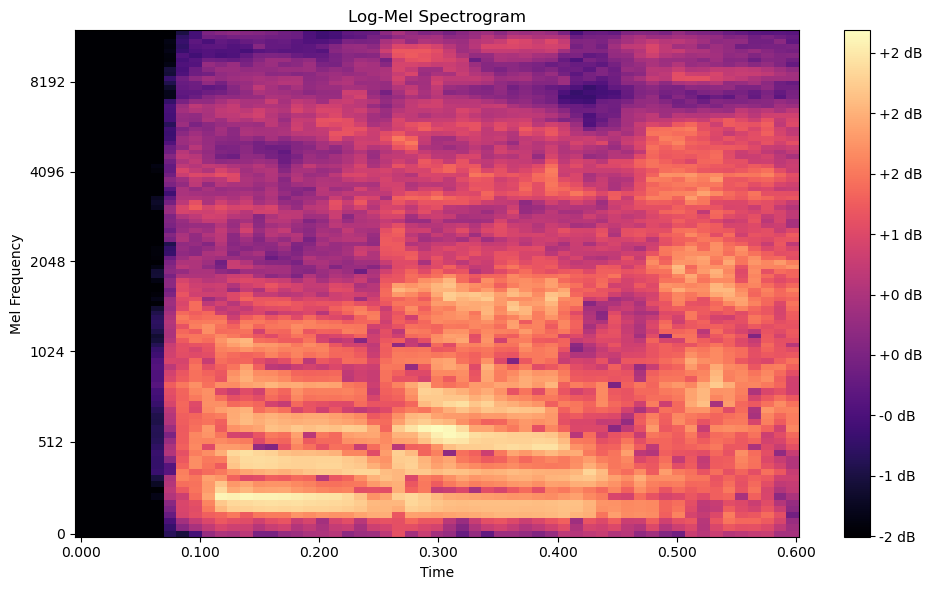

WAV file written to output.wav


In [8]:
import torch
import matplotlib.pyplot as plt
import librosa.display
import os
import soundfile as sf
import numpy as np
import torch
import librosa
import os
import utils

# Directory containing saved tensors

audio_sample = "/home/kunit17/Her/Data/Training_Samples"
# Function to plot Mel Spectrogram and Log-Mel Spectrogram

tensor_path = os.path.join(audio_sample, f"12345.wav")


# Load the audio file
signal, _ = librosa.load(tensor_path, sr=sr)

# Compute mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
np_max=mel_spectrogram

# Global normalization parameters (same as used during normalization)
global_mean = -51.277  # Replace with your calculated mean
global_std = 19.085    # Replace with your calculated std

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_fft, hop_length, sr, n_mels, _ = utils.get_audio_params()

# Directory where tensors are saved
tensor_directory = "/home/kunit17/Her/Data/Training_Mels"

# Specify the file name of the tensor to plot (without .pt extension)
tensor_file_name = "1234"  # Replace with the desired file name
tensor_path = os.path.join(tensor_directory, f"{tensor_file_name}.pt")

# Load the tensor
normalized_tensor = torch.load(tensor_path)

# Move the tensor to CPU if it's on GPU
normalized_tensor = normalized_tensor.cpu()

# Reverse normalization (denormalize the tensor)
denormalized_tensor = (normalized_tensor * global_std) + global_mean

# Convert tensors to NumPy arrays for plotting
normalized_log_mel = normalized_tensor.numpy()
denormalized_log_mel = denormalized_tensor.numpy()

# Plot the log-mel spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(
    normalized_log_mel,
    sr=24000,  # Replace with your sampling rate
    hop_length=256,  # Replace with your hop length
    x_axis="time",
    y_axis="mel",
    cmap="magma"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.tight_layout()
plt.show()

# Reverse Process
mel_spectrogram_reversed = librosa.db_to_power(denormalized_log_mel, ref=np.max(np_max))
linear_spectrogram = librosa.feature.inverse.mel_to_stft(mel_spectrogram_reversed, sr=sr, n_fft=n_fft)

# Use Griffin-Lim to reconstruct the signal
reconstructed_signal = librosa.griffinlim(linear_spectrogram, hop_length=hop_length, n_iter=64)

output_file = 'output.wav'  # Specify the output file name

# Ensure the signal is scaled to the appropriate range for WAV files
# WAV files typically expect 16-bit PCM, so we scale the signal to int16
scaled_signal = (reconstructed_signal * 32767).astype(np.int16)

# Write the WAV file
sf.write(output_file, scaled_signal, sr)  # Corrected argument order: data, samplerate
print(f"WAV file written to {output_file}")


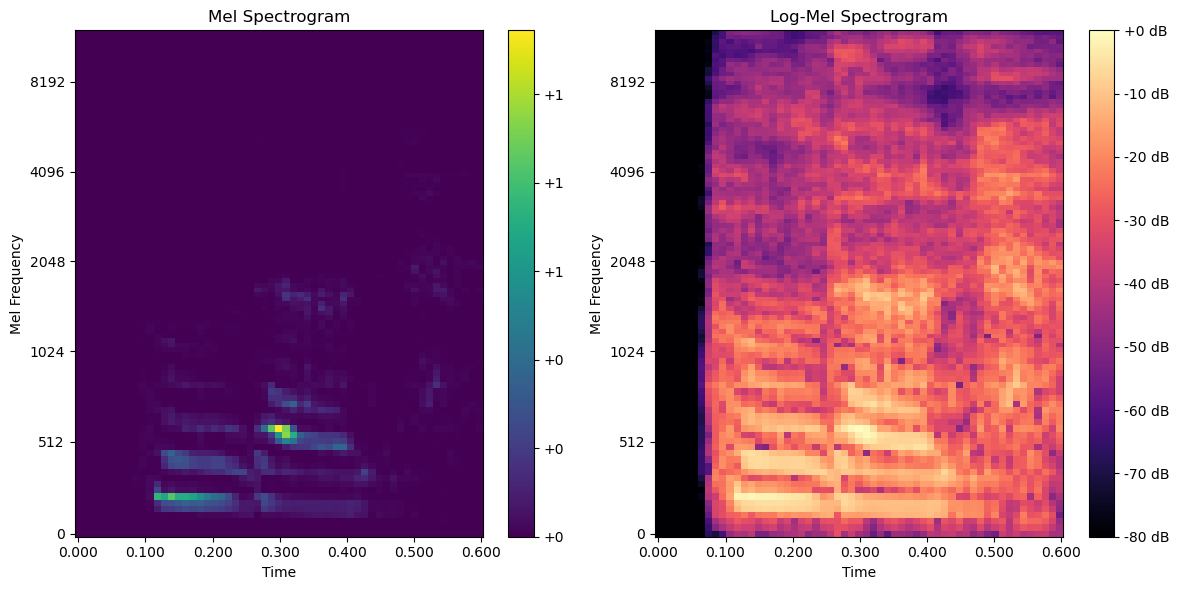

In [22]:
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Directory containing saved tensors
tensor_directory = "/home/kunit17/Her/Data/Training_Samples"
# Function to plot Mel Spectrogram and Log-Mel Spectrogram
def plot_spectrogram(tensor_key):
    tensor_path = os.path.join(tensor_directory, f"{tensor_key}.wav")
    
    if not os.path.exists(tensor_path):
        print(f"Tensor file {tensor_key}.pt not found in {tensor_directory}")
        return
    
    # Load the audio file
    signal, _ = librosa.load(tensor_path, sr=sr)
    
    # Compute mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    np_max=mel_spectrogram
    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot the Mel Spectrogram and Log-Mel Spectrogram
    plt.figure(figsize=(12, 6))

    # Mel Spectrogram
    plt.subplot(1, 2, 1)
    librosa.display.specshow(
        mel_spectrogram, sr=24000, hop_length=256, x_axis="time", y_axis="mel", cmap="viridis"
    )
    plt.colorbar(format="%+2.0f")
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")

    # Log-Mel Spectrogram
    plt.subplot(1, 2, 2)
    librosa.display.specshow(
        log_mel_spectrogram, sr=24000, hop_length=256, x_axis="time", y_axis="mel", cmap="magma"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Log-Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")

    plt.tight_layout()
    plt.show()

# Specify the key for the Mel spectrogram to visualize
tensor_key = "1234"  # Replace with the desired key
plot_spectrogram(tensor_key)
